In [1]:
from fastai2.basics import *
from fastai2.vision.all import *
from pathlib import Path

from mish_cuda import MishCuda
import cmasher as cmr
import gc
import scipy.cluster.hierarchy as hcluster

from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, roc_curve

seed = 256

%matplotlib inline

In [6]:
import sys
PATH = Path('../..').resolve()
sys.path.append(f'{PATH}/src')

from utils import *
metrics = [accuracy, F1Score(), Recall(), Precision()]

# Exploring the new SAGA data

In [3]:
saga = pd.read_csv(f'{PATH}/data/saga_redshifts_2021-02-11.csv', dtype={'OBJID': str})


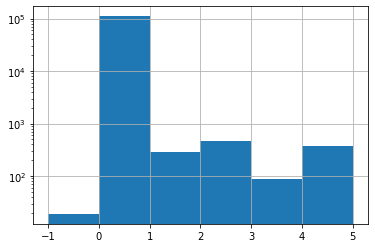

In [4]:
saga.SATS.hist(bins=range(-1, 6), log=True)

From Yao: 
> SATS == 1 means satellites. 3 means a MW-like host. You can ignore all other values.

In [5]:
(saga.SPEC_Z < 0.001).sum(), (saga.SPEC_Z < 0.02).sum(), (saga.SPEC_Z < 0.03).sum()

(0, 1241, 2550)

## Visualize a few lowz galaxies

In [6]:
lowz = saga[saga.SPEC_Z < 0.03].copy()

In [7]:
# lowz[['RA', 'DEC']][lowz.SPEC_Z < 0.03].sample(20)
# lowz[['RA', 'DEC']][lowz.SPEC_Z < 0.005].sample(20)

In [8]:
lowz[(lowz.SATS == -1)]

,OBJID,RA,DEC,r_mag,HOSTID,SPEC_Z,SATS
3509,904019530000002311,20.328230,12.411457,13.915704,b'nsa129387',0.002145,-1
11473,902395370000000185,50.135822,-15.904350,15.869822,b'nsa133355',0.002975,-1
17936,904746060000001891,172.335131,25.822903,21.159302,b'nsa139467',0.001734,-1
20559,903181560000003050,187.095849,-2.168261,18.685183,b'nsa141465',0.001587,-1
21500,903239180000002577,187.637156,-1.329577,17.713253,b'nsa141465',0.002402,-1
22509,903426620000004292,193.673371,2.104200,13.817690,b'nsa14409',0.002800,-1
23673,903527380000006285,194.018357,3.812773,15.531641,b'nsa14409',0.002061,-1
26280,915995330000004166,220.091589,54.224558,17.603740,b'nsa145297',0.002082,-1
28512,903427670000003879,219.942473,2.109266,19.510792,b'nsa145372',0.001160,-1
52588,915668420000000330,170.070112,45.389351,16.533625,b'nsa159593',0.002301,-1


In [9]:
lowz[(lowz.SATS == 1)][['RA', 'DEC']].sample(5)

,RA,DEC
14386,138.198210,35.159564
110107,355.066054,-12.523031
101821,317.919132,-49.456866
1804,9.016454,-8.266349
51464,145.234927,5.045009


## Hosts?

In [10]:
len(lowz.HOSTID.unique())

89

## View some images

In [12]:
saga.head()

,OBJID,RA,DEC,r_mag,HOSTID,SPEC_Z,SATS
0,904420480000001688,0.619167,19.821000,16.074575,b'nsa126115',0.089974,0
1,904420480000002421,0.667241,19.864357,20.517872,b'nsa126115',0.497183,0
2,904420480000002871,0.690822,19.872555,18.245674,b'nsa126115',0.330616,0
3,904420480000003409,0.717667,19.804723,16.816498,b'nsa126115',0.202619,0
4,904420490000000145,0.801847,19.849890,18.186575,b'nsa126115',0.212745,0


In [ ]:
objid = 915890360000002981
# Image.open(PATH/f'images-legacy_saga-2021-02-11/{objid}.jpg')

# Getting a CNN up to speed

In [3]:
saga = pd.read_csv(f'{PATH}/data/saga_redshifts_2021-02-11.csv', dtype={'OBJID': str})

df = saga.sample(frac=1).copy()
df['lower_z'] = df.SPEC_Z < 0.02
df['low_z'] = df.SPEC_Z < 0.03

# in order to use with previous utils
df['SPEC_FLAG'] = 1

In [70]:

legacy_image_stats = [np.array([0.14814416, 0.14217226, 0.13984123]), np.array([0.0881476 , 0.07823102, 0.07676626])]

item_tfms = [Resize(224)]
batch_tfms = (
    aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.) + 
    [Normalize.from_stats(*legacy_image_stats)]
)
seed = 256


def oversample(df: pd.DataFrame, num_oversample=None, label_column='lower_z'):
    """Oversample a `pd.DataFrame` such that `label_column` classes
    are balanced. Note that the result is not shuffled.
    """
    lst = [df]
    N_majority = (~df['lower_z']).sum()
    N_minority = ( df['lower_z']).sum()
    
    try:
        # -1 -> rebalance casses, other negative numbers will raise a ValueError
        if num_oversample == -1: num_oversample = N_majority - N_minority
        lst.append(df[df[label_column]].sample(num_oversample, replace=True))
    except ValueError:
        print('Make sure that `num_oversample` is larger than the number of objects in the label class')

    return pd.concat(lst)

def get_saga_dls(
    saga, 
    label_column='lower_z',
    split_column=None,
    oversample=None, 
    undersample=None, 
    valid_pct=0.25, 
    bs=64, 
    PATH=PATH,
    img_dir='images-legacy_saga-2021-02-11',
    item_tfms=item_tfms, 
    batch_tfms=batch_tfms, 
    seed=256,
):
    """Returns Dataloaders `dls` based on an input catalog `saga`. 
    If `undersample` is an integer, then it will sample fewer from the 
    nonsatellites class. If `oversample` is an integer, then it will sample
    that many satellites. User can also provide fraction of sample 
    for validation by supplying `valid_pct`.
    """
    
    
    is_low_z = (saga.SPEC_FLAG == 1) & (saga[label_column] == 1) # 1 == True

    if undersample is None:
        df = saga.copy()
    elif isinstance(undersample, int):
        df = pd.concat(
            (saga[~is_low_z].sample(undersample), saga[is_low_z]),
        )
    else:
        raise TypeError('Please enter an integer for `undersample`')
    
    if split_column is None:
        dblock = DataBlock(
            blocks=(ImageBlock, CategoryBlock),
            get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
            get_y=ColReader(label_column),
            splitter=RandomSplitter(valid_pct=valid_pct, seed=seed),
            item_tfms=item_tfms,
            batch_tfms=batch_tfms,
        )
    elif split_column in df.columns:
        dblock = DataBlock(
            blocks=(ImageBlock, CategoryBlock),
            get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
            get_y=ColReader(label_column),
            splitter=ColSplitter(split_column),
            item_tfms=item_tfms,
            batch_tfms=batch_tfms,
        )
    else:
        raise TypeError('Please enter a valid column for splitting train/valid subsets')
    
    dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=bs)
    
    if oversample is not None:
        return resample_dls(
            dls, label_column=label_column, split_column=split_column, num_oversample=oversample,
            bs=bs, PATH=PATH, item_tfms=item_tfms, batch_tfms=batch_tfms, seed=seed
        )
    else:
        return dls
    

def resample_dls(
    dls, 
    label_column='HAS_SAT_Z', 
    num_oversample=None,
    split_column=None,
    bs=64, PATH=PATH, 
    img_dir='images-legacy_saga-2021-02-11',
    item_tfms=item_tfms, 
    batch_tfms=batch_tfms, 
    seed=seed,
):
    """Given Dataloaders `dls` -- you may need to run `get_saga_dls()` first --
    oversample the satellites (generally outnumbered 100:1) in order to
    balance the classes. The classes are split by a binary `label_column`,
    which defaults to 'HAS_SAT_Z'. 
    
    Note that this method is probably not memory efficient.
    """
    train = dls.train.items.copy()
    valid = dls.valid.items.copy()

    train_oversampled = oversample(train, num_oversample=num_oversample, label_column=label_column)

    if split_column is None:
        split_column = 'is_valid'
        train_oversampled[split_column] = False
        valid[split_column] = True
        
    df_oversampled = pd.concat((train_oversampled, valid)).sample(frac=1)
    
    # create resampled datablock
    dblock_oversampled = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
        get_y=ColReader(label_column),
        splitter=ColSplitter(split_column),
        item_tfms=item_tfms,
        batch_tfms=batch_tfms,
    )

    return ImageDataLoaders.from_dblock(dblock_oversampled, df_oversampled, path=PATH, bs=bs)

## Training with artificially balanced training data and weighted loss

In [8]:
crossentropy_weights = tensor([0.1, 1.0])

### Train

In [56]:
K = 4
kf = KFold(K)

N = len(df)

df_folds = []

for k, [_, val_idx] in enumerate(kf.split(range(N))):
    
    print('======================')
    print(f'  Beginning fold {k+1}/{K}')
    print('======================')
    
    # perform k-fold split on dataframe
    val_mask = np.zeros((N,), dtype=bool)
    val_mask[val_idx] = True
    
    df['kfold_split'] = val_mask
    
    # use splitter/labeler to resample df -- maximize completeness for z < 0.02
    dls = get_saga_dls(
        df, 
        label_column='lower_z', 
        split_column='kfold_split',
        oversample=10000,  # no undersampling, oversample to get to ~10:1
        PATH=PATH,
        seed=seed,
        bs=64,
    )
    
    # load model and fine-tune
    model = xse_resnext18(n_out=1, sa=True, act_cls=MishCuda)
    learn = Learner(
        dls, model, 
        opt_func=ranger, 
        metrics=metrics,
        loss_func=nn.CrossEntropyLoss(weight=crossentropy_weights).cuda(), #completeness
    )
    learn = learn.load('metallicity-legacy-xse_xresnet18');
    learn.freeze()

    learn.model[-1] = nn.Linear(512, 2)

    learn.fit_one_cycle(1, 5e-2, div_final=100)
    
    # keep track of model
    torch.save(learn.model.state_dict(), f'{PATH}/models/saga-s2+_completeness-lower-z-{k}.pth')
    
    # get and save predictions on validation set
    p_lower_z, true_lower_z = learn.get_preds()
    p_lower_z.argmax(1).sum()
    
    valid = dls.valid.items.copy()
    valid['pred_lower_z'] = p_lower_z.softmax(1)[:,1].numpy()
    
    df_folds.append(valid)
    
    print(confusion_matrix(valid.lower_z, p_lower_z.argmax(1).numpy()))
    
    del learn, model, dls
    gc.collect()

  Beginning fold 1/4


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,precision_score,time
0,0.105565,0.121658,0.958853,0.340206,0.961165,0.206681,05:11


[[26548  1140]
 [   12   297]]
  Beginning fold 2/4


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,precision_score,time
0,0.117997,0.167951,0.942530,0.270295,0.949045,0.157589,05:11


[[26090  1593]
 [   16   298]]
  Beginning fold 3/4


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,precision_score,time
0,0.096942,0.138851,0.949316,0.297872,0.964744,0.176126,05:11


[[26277  1408]
 [   11   301]]
  Beginning fold 4/4


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,precision_score,time
0,0.102760,0.150361,0.948673,0.290370,0.960784,0.171030,05:11


[[26266  1425]
 [   12   294]]


In [57]:
results_1 = pd.concat(df_folds)
results_1[results_1.lower_z].sort_values('pred_lower_z')

,OBJID,RA,DEC,r_mag,HOSTID,SPEC_Z,SATS,lower_z,low_z,SPEC_FLAG,kfold_split,pred_lower_z
32041,903269440000002366,224.100026,-0.788616,21.353190,b'nsa145729',0.017135,2,True,True,1,True,0.002493
81581,903082000000005111,216.543059,-3.939433,17.461110,b'nsa35340',0.003299,4,True,True,1,True,0.004438
96869,901691420000003576,40.192221,-29.160311,21.318077,b'pgc10330',0.001370,-1,True,True,1,True,0.004791
24477,915555500000000744,209.269379,42.810995,19.355670,b'nsa144151',0.019900,2,True,True,1,True,0.006596
108499,900303530000003310,332.266297,-65.459349,17.486425,b'pgc68312',0.019122,2,True,True,1,True,0.007055
...,...,...,...,...,...,...,...,...,...,...,...,...
98584,902162640000003195,53.810562,-20.373787,12.346691,b'pgc13108',0.003566,4,True,True,1,True,0.999999
104283,901018750000004991,323.146853,-44.067618,11.133083,b'pgc66934',0.008966,3,True,True,1,True,0.999999
60225,903499470000004935,215.265358,3.270923,10.406211,b'nsa164865',0.004943,3,True,True,1,True,0.999999
110119,902616900000001860,354.974195,-12.292852,10.257168,b'pgc72060',0.005891,3,True,True,1,True,1.000000


In [58]:
print(confusion_matrix(results_1.lower_z, results_1.pred_lower_z > 0.5))


[[105181   5566]
 [    51   1190]]


In [60]:
print(confusion_matrix(results_1.low_z, results_1.pred_lower_z > 0.5))


[[104934   4504]
 [   298   2252]]


In [67]:
# results_1.to_csv(f'{PATH}/results/desi-sv/z_02-complete.csv', index=False)

In [69]:
# visualize
# results_1[results_1.lower_z].sort_values('pred_lower_z')[['RA', 'DEC']].head(20)

### ~~Combine models from k folds?~~

In [52]:
for k in range(4):
    if k == 0:
        sd = torch.load(f'{PATH}/models/saga-s2+_completeness-lower-z-{k}.pth')
    else:
        sd_k = torch.load(f'{PATH}/models/saga-s2+_completeness-lower-z-{k}.pth')
        
        for key in sd:
            sd[key] += sd_k[key]
            
            if k == 3:
                sd[key] /= 4

torch.save(sd, f'{PATH}/models/saga-s2+_completeness-lower-z.pth')


### ~~And make prediction~~

In [27]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader(['OBJID'], pref=f'{PATH}/images-legacy_saga-2021-02-11/', suff='.jpg'),
    get_y=ColReader('low_z'),
    splitter=RandomSplitter(0),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=128)

# load model 
model = xse_resnext18(n_out=2, sa=True, act_cls=MishCuda)
learn = Learner(
    dls, model, 
    opt_func=ranger, 
    metrics=metrics,
    loss_func=nn.CrossEntropyLoss(weight=crossentropy_weights).cuda(),  #completeness
)

learn.load(f'{PATH}/models/saga-s2+_completeness-lower-z')

# get test set
dl_test = learn.dls.test_dl(df, with_labels=True)
p_low_z, true_low_z  = learn.get_preds(dl=dl_test)

test_df = dls.train.items.copy()
test_df['pred_low_z'] = p_low_z.softmax(1)[:,1].numpy()
print(confusion_matrix(test_df.low_z, test_df.pred_low_z > 0.5))


[[62925 46513]
 [ 1436  1114]]


## z < 0.03 completeness

In [71]:
K = 4
kf = KFold(K)

N = len(df)

df_folds = []

for k, [_, val_idx] in enumerate(kf.split(range(N))):
    
    print('======================')
    print(f'  Beginning fold {k+1}/{K}')
    print('======================')
    
    # perform k-fold split on dataframe
    val_mask = np.zeros((N,), dtype=bool)
    val_mask[val_idx] = True
    
    df['kfold_split'] = val_mask
    
    # use splitter/labeler to resample df -- maximize completeness for z < 0.03
    dls = get_saga_dls(
        df, 
        label_column='low_z', 
        split_column='kfold_split',
        oversample=10000, 
        PATH=PATH,
        seed=seed,
    )
    
    # load model and fine-tune
    model = xse_resnext18(n_out=1, sa=True, act_cls=MishCuda)
    learn = Learner(
        dls, model, 
        opt_func=ranger, 
        metrics=metrics,
        loss_func=nn.CrossEntropyLoss(weight=crossentropy_weights).cuda(),  #completeness
    )
    learn = learn.load('metallicity-legacy-xse_xresnet18');
    learn.freeze()

    learn.model[-1] = nn.Linear(512, 2)

    learn.fit_one_cycle(1, 5e-2, div_final=100)
    
    # keep track of model
    torch.save(learn.model.state_dict(), f'{PATH}/models/saga-s2+_completeness-low-z-{k}.pth')
    
    # get and save predictions on validation set
    p_low_z, true_low_z = learn.get_preds()
    p_low_z.argmax(1).sum()
    
    valid = dls.valid.items.copy()
    valid['pred_low_z'] = p_low_z.softmax(1)[:,1].numpy()
    
    df_folds.append(valid)
    
    print(confusion_matrix(valid.low_z, p_low_z.argmax(1).numpy()))
    
    del learn, model, dls
    gc.collect()

  Beginning fold 1/4


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,precision_score,time
0,0.171818,0.189938,0.922385,0.351537,0.933439,0.216544,05:10


[[25235  2131]
 [   42   589]]
  Beginning fold 2/4


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,precision_score,time
0,0.155600,0.236486,0.895203,0.303088,0.974046,0.179466,05:09


[[24425  2917]
 [   17   638]]
  Beginning fold 3/4


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,precision_score,time
0,0.156408,0.179735,0.927135,0.381443,0.951589,0.238529,05:09


[[25328  2008]
 [   32   629]]
  Beginning fold 4/4


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,precision_score,time
0,0.155943,0.186640,0.923528,0.350228,0.956882,0.214339,05:09


[[25279  2115]
 [   26   577]]


In [72]:
results_2 = pd.concat(df_folds)
results_2.to_csv(f'{PATH}/results/desi-sv/z_03-complete.csv', index=False)

In [79]:
print(confusion_matrix(results_2.lower_z, results_2.pred_low_z > 0.5))
print(confusion_matrix(results_2.low_z, results_2.pred_low_z > 0.5))


[[100354  10393]
 [    30   1211]]
[[100267   9171]
 [   117   2433]]


### ~~Combined models~~

In [30]:
# combine (average) these models by loading in the first, 
# and then adding subsequent ones, and finally dividing by four


for k in range(4):
    if k == 0:
        sd = torch.load(f'{PATH}/models/saga-s2+_completeness-low-z-{k}.pth')
    else:
        sd_k = torch.load(f'{PATH}/models/saga-s2+_completeness-low-z-{k}.pth')
        
        for key in sd:
            sd[key] += sd_k[key]
            
            if k == 3:
                sd[key] /= 4

torch.save(sd, f'{PATH}/models/saga-s2+_completeness-low-z.pth')


In [40]:
# dls = get_saga_dls(
#     df, 
#     label_column='low_z', 
#     split_column='kfold_split',
#     oversample=True, 
#     undersample=20000, 
#     PATH=PATH,
#     seed=seed,
# )

# # load model and fine-tune
# model = xse_resnext18(n_out=2, sa=True, act_cls=MishCuda)
# learn = Learner(
#     dls, model, 
#     opt_func=ranger, 
#     metrics=metrics,
#     loss_func=nn.CrossEntropyLoss(weight=crossentropy_weights).cuda(),  #completeness
# )

# learn.load(f'{PATH}/models/saga-s2+_completeness-low-z')


p_lower_z, true_lower_z = learn.get_preds()
valid = dls.valid.items.copy()
valid['pred_lower_z'] = p_lower_z.softmax(1)[:,1].numpy()
print(confusion_matrix(valid.lower_z, valid['pred_lower_z'] > 0.5))


[[3224 2115]
 [   4  330]]


## z < 0.03 *purity* (with overresampling)

In [82]:
K = 4
kf = KFold(K)

N = len(df)

df_folds = []

for k, [_, val_idx] in enumerate(kf.split(range(N))):
    
    print('======================')
    print(f'  Beginning fold {k+1}/{K}')
    print('======================')
    
    # perform k-fold split on dataframe
    val_mask = np.zeros((N,), dtype=bool)
    val_mask[val_idx] = True
    
    df['kfold_split'] = val_mask
    
    # use splitter/labeler to resample df
    dls = get_saga_dls(
        df, 
        label_column='low_z', 
        split_column='kfold_split',
        oversample=60000, 
        PATH=PATH,
        seed=seed,
        bs=128,
    )
    
    # load model and fine-tune
    model = xse_resnext18(n_out=1, sa=True, act_cls=MishCuda)
    learn = Learner(
        dls, model, 
        opt_func=ranger, 
        loss_func=LabelSmoothingCrossEntropy(eps=0.05), # purity
        metrics=metrics,
    )
    learn = learn.load('metallicity-legacy-xse_xresnet18');
    learn.freeze()

    learn.model[-1] = nn.Linear(512, 2)

    learn.fit_one_cycle(3, 1e-2) # note different training loop
    
    # keep track of model
    torch.save(learn.model.state_dict(), f'{PATH}/models/saga-s2+_purity-low-z-{k}.pth')
    
    # get and save predictions on validation set
    p_low_z, true_low_z = learn.get_preds()
    p_low_z.argmax(1).sum()
    
    valid = dls.valid.items.copy()
    valid['pred_low_z'] = p_low_z.softmax(1)[:,1].numpy()
    
    df_folds.append(valid)
    
    print(confusion_matrix(valid.low_z, p_low_z.argmax(1).numpy()))
    
    del learn, model, dls
    gc.collect()

  Beginning fold 1/4
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,precision_score,time
0,0.214894,0.205811,0.950923,0.449519,0.889065,0.300804,07:05
1,0.180445,0.215783,0.950173,0.455716,0.925515,0.302277,07:05
2,0.166412,0.174056,0.973390,0.598383,0.879556,0.453431,07:05


[[26697   669]
 [   76   555]]
  Beginning fold 2/4
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,precision_score,time
0,0.216481,0.274060,0.916670,0.349233,0.955725,0.213652,07:04
1,0.176353,0.207710,0.955852,0.497969,0.935878,0.339236,07:04
2,0.163006,0.178307,0.970640,0.590637,0.905344,0.438285,07:04


[[26582   760]
 [   62   593]]
  Beginning fold 3/4
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,precision_score,time
0,0.218313,0.210338,0.948102,0.458038,0.928896,0.303960,07:05
1,0.171482,0.196765,0.963353,0.537004,0.900151,0.382637,07:05
2,0.159047,0.175325,0.971961,0.594734,0.871407,0.451411,07:05


[[26636   700]
 [   85   576]]
  Beginning fold 4/4
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,precision_score,time
0,0.214208,0.217661,0.950852,0.446945,0.922056,0.294960,07:05
1,0.180297,0.211413,0.954459,0.467196,0.927032,0.312291,07:04
2,0.160195,0.179638,0.969782,0.554737,0.873964,0.406322,07:05


[[26624   770]
 [   76   527]]


In [83]:
results_3 = pd.concat(df_folds)
results_3.to_csv(f'{PATH}/results/desi-sv/z_03-purity.csv', index=False)

In [84]:
print(confusion_matrix(results_3.lower_z, results_3.pred_low_z > 0.5))
print(confusion_matrix(results_3.low_z, results_3.pred_low_z > 0.5))


[[106766   3981]
 [    72   1169]]
[[106539   2899]
 [   299   2251]]


### No resampling

In [103]:
K = 4
kf = KFold(K)

N = len(df)

df_folds = []

for k, [_, val_idx] in enumerate(kf.split(range(N))):
    
    print('======================')
    print(f'  Beginning fold {k+1}/{K}')
    print('======================')
    
    # perform k-fold split on dataframe
    val_mask = np.zeros((N,), dtype=bool)
    val_mask[val_idx] = True
    
    df['kfold_split'] = val_mask
    
    # use splitter/labeler to resample df
    dls = get_saga_dls(
        df, 
        label_column='low_z', 
        split_column='kfold_split',
        oversample=None, 
        PATH=PATH,
        seed=seed,
        bs=128,
    )
    
    # load model and fine-tune
    model = xse_resnext18(n_out=1, sa=True, act_cls=MishCuda)
    learn = Learner(
        dls, model, 
        opt_func=ranger, 
        loss_func=LabelSmoothingCrossEntropy(eps=0.05), # purity
        metrics=metrics,
    )
    learn = learn.load('metallicity-legacy-xse_xresnet18');
    learn.freeze()

    learn.model[-1] = nn.Linear(512, 2)

    learn.fit_one_cycle(3, 1e-2) # note different training loop
    
    # keep track of model
    torch.save(learn.model.state_dict(), f'{PATH}/models/saga-s2+_purity-low-z-{k}.pth')
    
    # get and save predictions on validation set
    p_low_z, true_low_z = learn.get_preds()
    p_low_z.argmax(1).sum()
    
    valid = dls.valid.items.copy()
    valid['pred_low_z'] = p_low_z.softmax(1)[:,1].numpy()
    
    df_folds.append(valid)
    
    print(confusion_matrix(valid.low_z, p_low_z.argmax(1).numpy()))
    
    del learn, model, dls
    gc.collect()

  Beginning fold 1/4
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,precision_score,time
0,0.149941,0.146057,0.986320,0.643721,0.548336,0.779279,04:21
1,0.143692,0.145059,0.986927,0.621118,0.475436,0.895522,04:21
2,0.142680,0.142819,0.987677,0.698163,0.632330,0.779297,04:20


[[27253   113]
 [  232   399]]
  Beginning fold 2/4
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,precision_score,time
0,0.149930,0.148901,0.985748,0.673753,0.629008,0.725352,04:20
1,0.143081,0.144147,0.986606,0.647887,0.526718,0.841463,04:20
2,0.141951,0.143033,0.987070,0.700826,0.647328,0.763964,04:20


[[27211   131]
 [  231   424]]
  Beginning fold 3/4
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,precision_score,time
0,0.151617,0.145712,0.986784,0.650943,0.521936,0.864662,04:20
1,0.141717,0.144605,0.986641,0.699357,0.658094,0.746141,04:20
2,0.141558,0.143573,0.986570,0.691297,0.636914,0.755835,04:20


[[27200   136]
 [  240   421]]
  Beginning fold 4/4
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,precision_score,time
0,0.147713,0.144377,0.987356,0.652259,0.550580,0.800000,04:20
1,0.145103,0.142328,0.987820,0.702183,0.666667,0.741697,04:20
2,0.144043,0.141061,0.988320,0.709333,0.661692,0.764368,04:21


[[27271   123]
 [  204   399]]


In [104]:
results_3 = pd.concat(df_folds)
results_3.to_csv(f'{PATH}/results/desi-sv/z_03-purity.csv', index=False)

In [105]:
print(confusion_matrix(results_3.lower_z, results_3.pred_low_z > 0.5))
print(confusion_matrix(results_3.low_z, results_3.pred_low_z > 0.5))

[[109633   1114]
 [   209   1032]]
[[108935    503]
 [   907   1643]]


### Custom weird model...

In [ ]:
K = 4
kf = KFold(K)

N = len(df)

df_folds = []

for k, [_, val_idx] in enumerate(kf.split(range(N))):
    
    print('======================')
    print(f'  Beginning fold {k+1}/{K}')
    print('======================')
    
    # perform k-fold split on dataframe
    val_mask = np.zeros((N,), dtype=bool)
    val_mask[val_idx] = True
    
    df['kfold_split'] = val_mask
    
    # use splitter/labeler to resample df
    dls = get_saga_dls(
        df, 
        label_column='low_z', 
        split_column='kfold_split',
        oversample=100000,           # note 100k...
        PATH=PATH,
        seed=seed,
        bs=128,
    )
    
    # new xresnet9-like model
    model = XResNet(ResBlock, 1, [1, 1, 1, 1], n_out=2, sa=True, act_cls=MishCuda)
    learn = Learner(
        dls, model, 
        opt_func=ranger, 
        loss_func=LabelSmoothingCrossEntropy(eps=0.05), # purity
        metrics=metrics,
    )

    learn.fit_one_cycle(5, 1e-2) # note different training loop
    
    # get and save predictions on validation set
    p_low_z, true_low_z = learn.get_preds()
    p_low_z.argmax(1).sum()
    
    valid = dls.valid.items.copy()
    valid['pred_low_z'] = p_low_z.softmax(1)[:,1].numpy()
    
    df_folds.append(valid)
    
    print(confusion_matrix(valid.low_z, p_low_z.argmax(1).numpy()))
    
    del learn, model, dls
    gc.collect()

In [90]:
print(confusion_matrix(valid.lower_z, valid.pred_low_z > 0.5))
print(confusion_matrix(valid.low_z, valid.pred_low_z > 0.5))


[[26780   908]
 [   21   288]]
[[26711   655]
 [   90   541]]


### deconv/hybrid model

In [95]:
import sys
sys.path.append('/home/jupyter/morphological-spectra/src')
from xresnet_deconv import *


In [98]:
K = 4
kf = KFold(K)

N = len(df)

df_folds = []

for k, [_, val_idx] in enumerate(kf.split(range(N))):
    
    print('======================')
    print(f'  Beginning fold {k+1}/{K}')
    print('======================')
    
    # perform k-fold split on dataframe
    val_mask = np.zeros((N,), dtype=bool)
    val_mask[val_idx] = True
    
    df['kfold_split'] = val_mask
    
    # use splitter/labeler to resample df
    dls = get_saga_dls(
        df, 
        label_column='low_z', 
        split_column='kfold_split',
        oversample=60000, 
        PATH=PATH,
        seed=seed,
        bs=128,
    )
    
    # hybrid deconv-xresnet18
    model = xresnet18_hybrid(n_out=2, sa=True, act_cls=MishCuda, groups=64, reduction=8)
    
    learn = Learner(
        dls, model, 
        opt_func=ranger, 
        loss_func=LabelSmoothingCrossEntropy(eps=0.05), # purity
        metrics=metrics,
    )

    learn.fit_one_cycle(5, 1e-2) # note different training loop
    
    # get and save predictions on validation set
    p_low_z, true_low_z = learn.get_preds()
    p_low_z.argmax(1).sum()
    
    valid = dls.valid.items.copy()
    valid['pred_low_z'] = p_low_z.softmax(1)[:,1].numpy()
    
    df_folds.append(valid)
    
    print(confusion_matrix(valid.low_z, p_low_z.argmax(1).numpy()))
    
    del learn, model, dls
    gc.collect()

  Beginning fold 1/4
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,precision_score,time
0,0.254338,0.337295,0.912955,0.324369,0.927100,0.196573,07:22
1,0.205122,0.221607,0.951816,0.444170,0.854200,0.300111,07:22
2,0.175142,0.177841,0.972783,0.579006,0.830428,0.444444,07:22
3,0.157304,0.166176,0.977998,0.624390,0.811410,0.507433,07:22
4,0.146322,0.168394,0.977176,0.619416,0.824089,0.496183,07:22


KeyboardInterrupt: 

In [100]:
p_low_z, true_low_z = learn.get_preds()
p_low_z.argmax(1).sum()

valid = dls.valid.items.copy()
valid['pred_low_z'] = p_low_z.softmax(1)[:,1].numpy()

df_folds.append(valid)

print(confusion_matrix(valid.lower_z, valid.pred_low_z > 0.5))
print(confusion_matrix(valid.low_z, valid.pred_low_z > 0.5))


[[26928   760]
 [   21   288]]
[[26838   528]
 [  111   520]]


### Hybrid model, no resampling or weighted loss, cross entropy with label smoothing (eps=0.1)

In [101]:
K = 4
kf = KFold(K)

N = len(df)

df_folds = []

for k, [_, val_idx] in enumerate(kf.split(range(N))):
    
    print('======================')
    print(f'  Beginning fold {k+1}/{K}')
    print('======================')
    
    # perform k-fold split on dataframe
    val_mask = np.zeros((N,), dtype=bool)
    val_mask[val_idx] = True
    
    df['kfold_split'] = val_mask
    
    # use splitter/labeler to resample df
    dls = get_saga_dls(
        df, 
        label_column='low_z', 
        split_column='kfold_split',
        oversample=None, 
        PATH=PATH,
        seed=seed,
        bs=128,
    )
    
    # hybrid deconv-xresnet18
    model = xresnet18_hybrid(n_out=2, sa=True, act_cls=MishCuda, groups=64, reduction=8)
    
    learn = Learner(
        dls, model, 
        opt_func=ranger, 
        loss_func=LabelSmoothingCrossEntropy(eps=0.1), # purity
        metrics=metrics,
    )

    learn.fit_one_cycle(5, 1e-2) # note different training loop
    
    # get and save predictions on validation set
    p_low_z, true_low_z = learn.get_preds()
    p_low_z.argmax(1).sum()
    
    valid = dls.valid.items.copy()
    valid['pred_low_z'] = p_low_z.softmax(1)[:,1].numpy()
    
    df_folds.append(valid)
    
    print(confusion_matrix(valid.low_z, p_low_z.argmax(1).numpy()))
    
    del learn, model, dls
    gc.collect()

  Beginning fold 1/4
@log_args had an issue on LabelSmoothingCrossEntropy.__init__ -> missing a required argument: 'self'


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,precision_score,time
0,0.238575,0.238966,0.979891,0.227709,0.131537,0.846939,04:27
1,0.229729,0.236323,0.980248,0.220028,0.123613,1.000000,04:28
2,0.229752,0.225779,0.984784,0.571429,0.450079,0.782369,04:29
3,0.224553,0.223505,0.985677,0.621341,0.521395,0.768692,04:29
4,0.223853,0.222168,0.986249,0.645161,0.554675,0.770925,04:29


[[27262   104]
 [  281   350]]
  Beginning fold 2/4


KeyboardInterrupt: 

In [102]:
print(confusion_matrix(valid.lower_z, valid.pred_low_z > 0.5))
print(confusion_matrix(valid.low_z, valid.pred_low_z > 0.5))


[[27470   218]
 [   73   236]]
[[27262   104]
 [  281   350]]


## ~~No undersampling data, but oversample, and keep weighted loss~~
Takes too long, results aren't any better...

## ~~Only undersample~~

In [48]:
crossentropy_weights = tensor([0.1, 1.0])

In [49]:
K = 5
kf = KFold(K)

N = len(df)

df_folds = []

for k, [_, val_idx] in enumerate(kf.split(range(N))):
    
    print('======================')
    print(f'  Beginning fold {k+1}/{K}')
    print('======================')
    
    # perform k-fold split on dataframe
    val_mask = np.zeros((N,), dtype=bool)
    val_mask[val_idx] = True
    
    df['kfold_split'] = val_mask
    
    # use splitter/labeler to resample df -- maximize completeness for z < 0.02
    dls = get_saga_dls(
        df, 
        label_column='lower_z', 
        split_column='kfold_split',
        oversample_satellites=False, 
        undersample_nonsatellites=20000, 
        PATH=PATH,
        seed=seed,
    )
    
    # load model and fine-tune
    model = xse_resnext18(n_out=1, sa=True, act_cls=MishCuda)
    learn = Learner(
        dls, model, 
        opt_func=ranger, 
        metrics=metrics,
        loss_func=nn.CrossEntropyLoss(weight=crossentropy_weights).cuda(),
    )
    learn = learn.load('metallicity-legacy-xse_xresnet18');
    learn.freeze()

    learn.model[-1] = nn.Linear(512, 2)

    learn.fit_one_cycle(3, 5e-2, div_final=100)
    
    # get and save predictions on validation set
    p_lower_z, true_lower_z = learn.get_preds()
    p_lower_z.argmax(1).sum()
    
    valid = dls.valid.items.copy()
    valid['pred_lower_z'] = p_lower_z.softmax(1)[:,1].numpy()
    
    df_folds.append(valid)
    
    print(confusion_matrix(valid.lower_z, p_lower_z.argmax(1).numpy()))
    
    del learn, model, dls
    gc.collect()

  Beginning fold 1/5


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,precision_score,time
0,0.235007,0.123442,0.949940,0.661290,0.861345,0.536649,00:57
1,0.183843,0.084940,0.974255,0.787402,0.840336,0.740741,00:57
2,0.145649,0.083515,0.971156,0.788831,0.949580,0.674627,00:57


[[3848  109]
 [  12  226]]
  Beginning fold 2/5


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,precision_score,time
0,0.252980,0.226284,0.912639,0.545894,0.953586,0.382403,00:57
1,0.180883,0.077868,0.975139,0.799250,0.898734,0.719595,00:57
2,0.123500,0.104603,0.961431,0.734824,0.970464,0.591260,00:57


[[3908  159]
 [   7  230]]
  Beginning fold 3/5


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,precision_score,time
0,0.241586,0.183311,0.922305,0.559023,0.872881,0.411178,00:57
1,0.185265,0.477859,0.818073,0.375718,0.970339,0.232960,00:57
2,0.117639,0.111347,0.958642,0.718699,0.936441,0.583113,00:57


[[3789  158]
 [  15  221]]
  Beginning fold 4/5


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,precision_score,time
0,0.213311,0.149785,0.941259,0.652893,0.871324,0.522026,00:57
1,0.188271,0.120923,0.953846,0.714697,0.911765,0.587678,00:57
2,0.113869,0.103585,0.964336,0.769925,0.941176,0.651399,00:57


[[3881  137]
 [  16  256]]
  Beginning fold 5/5


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,precision_score,time
0,0.208886,0.477842,0.791794,0.358382,0.961240,0.220249,00:57
1,0.186293,0.167095,0.932239,0.629962,0.953488,0.470363,00:57
2,0.136358,0.094097,0.967878,0.782194,0.953488,0.663073,00:57


[[3882  125]
 [  12  246]]


In [51]:
results_3 = pd.concat(df_folds)
results_3[results_3.lower_z].sort_values('pred_lower_z')

,OBJID,RA,DEC,r_mag,HOSTID,SPEC_Z,SATS,lower_z,low_z,SPEC_FLAG,kfold_split,pred_lower_z
21500,903239180000002577,187.637156,-1.329577,17.713253,b'nsa141465',0.002402,-1,True,True,1,True,0.001495
1351,902787430000002407,8.435148,-8.961253,18.370123,b'nsa127226',0.015186,2,True,True,1,True,0.002237
76447,904292520000001565,234.165401,17.363759,18.919786,b'nsa166313',0.014688,2,True,True,1,True,0.003630
20559,903181560000003050,187.095849,-2.168261,18.685183,b'nsa141465',0.001587,-1,True,True,1,True,0.004348
81581,903082000000005111,216.543059,-3.939433,17.461110,b'nsa35340',0.003299,4,True,True,1,True,0.004864
...,...,...,...,...,...,...,...,...,...,...,...,...
111697,901226470000005918,38.392998,-39.044589,10.604064,b'pgc9747',0.006448,3,True,True,1,True,0.999997
10804,902422950000001822,45.910093,-15.613451,10.962917,b'nsa133115',0.008573,3,True,True,1,True,0.999998
109147,900334400000005381,331.708788,-64.316296,10.872554,b'pgc68312',0.009610,4,True,True,1,True,0.999998
98362,902135620000004788,53.012675,-20.818698,10.979018,b'pgc13108',0.005154,3,True,True,1,True,0.999998


In [55]:
print(confusion_matrix(results_3.lower_z, results_3.pred_lower_z > 0.5))


[[19308   688]
 [   62  1179]]


95% completeness, 63% purity for $z < 0.02$

In [77]:
results_3[results_3.lower_z].sort_values('pred_lower_z')[['RA', 'DEC']].head(20)

,RA,DEC
21500,187.637156,-1.329577
1351,8.435148,-8.961253
76447,234.165401,17.363759
20559,187.095849,-2.168261
81581,216.543059,-3.939433
32041,224.100026,-0.788616
108630,335.408256,-65.267365
28512,219.942473,2.109266
108499,332.266297,-65.459349
24477,209.269379,42.810995


What is the performance on $0.02 < z < 0.03$? wait where are these galaxies??????

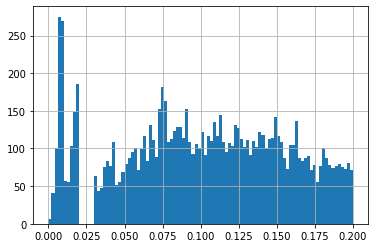

In [71]:
results_3.SPEC_Z.hist(bins=100, range=[0, 0.2])

## ~~No rebalancing~~

In [90]:
K = 5
kf = KFold(K)

N = len(df)

df_folds = []

for k, [_, val_idx] in enumerate(kf.split(range(N))):
    
    print('======================')
    print(f'  Beginning fold {k+1}/{K}')
    print('======================')
    
    # perform k-fold split on dataframe
    val_mask = np.zeros((N,), dtype=bool)
    val_mask[val_idx] = True
    
    df['kfold_split'] = val_mask
    
    # use splitter/labeler to resample df -- maximize completeness for z < 0.02
    dls = get_saga_dls(
        df, 
        label_column='lower_z', 
        split_column='kfold_split',
        oversample_satellites=False, 
        undersample_nonsatellites=None, 
        PATH=PATH,
        seed=seed,
    )
    
    # load model and fine-tune
    model = xse_resnext18(n_out=1, sa=True, act_cls=MishCuda)
    learn = Learner(
        dls, model, 
        opt_func=ranger, 
        metrics=metrics,
        loss_func=nn.CrossEntropyLoss(weight=crossentropy_weights).cuda(),
    )
    learn = learn.load('metallicity-legacy-xse_xresnet18');
    learn.freeze()

    learn.model[-1] = nn.Linear(512, 2)

    learn.fit_one_cycle(3, 5e-2, div_final=100)
    
    # get and save predictions on validation set
    p_lower_z, true_lower_z = learn.get_preds()
    p_lower_z.argmax(1).sum()
    
    valid = dls.valid.items.copy()
    valid['pred_lower_z'] = p_lower_z.softmax(1)[:,1].numpy()
    
    df_folds.append(valid)
    
    print(confusion_matrix(valid.lower_z, p_lower_z.argmax(1).numpy()))
    
    del learn, model, dls
    gc.collect()

  Beginning fold 1/5


epoch,train_loss,valid_loss,accuracy,f1_score,recall_score,precision_score,time
0,0.119354,0.141437,0.989519,0.486726,0.462185,0.514019,04:52
1,0.113417,0.103080,0.983601,0.497925,0.756303,0.371134,04:51
2,0.089204,0.079486,0.985317,0.537696,0.794118,0.406452,04:51


[[21621   276]
 [   49   189]]
  Beginning fold 2/5


KeyboardInterrupt: 

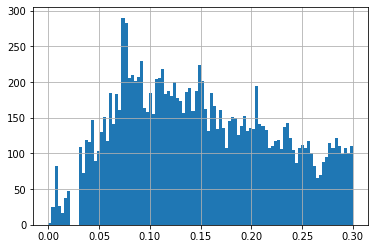

In [93]:
df_folds[0].SPEC_Z.hist(bins=100, range=[0, 0.3])

# WIP: Joint prediction of $z < 0.02$ and $z < 0.03$?

Main issue is that I need to update all of the `utils` code so that they can handle multiple predictions. An easier way (perhaps) is to make separate predictions on the two redshift regimes.

In [ ]:
crossentropy_weights = tensor([0.1, 1.0, 0.3, 0.3])

In [43]:
def oversample(df: pd.DataFrame, label_column='lower_z'):
    """Oversample a `pd.DataFrame` such that `label_column` classes
    are balanced. Note that the result is not shuffled.
    
    See https://gist.github.com/scart97/8c33b84db8d6375739b57afab1355900
    """
    max_size = np.max(list(df.lower_z.value_counts()) + list(df.low_z.value_counts()))
    lst = [df]
    for class_index, group in df.groupby(label_column):
        lst.append(group.sample(max_size-len(group), replace=True))
    return pd.concat(lst)


def get_saga_dls(
    saga, 
    label_column=['lower_z'],
    split_column=None,
    oversample_satellites=True, 
    undersample_nonsatellites=None, 
    valid_pct=0.25, 
    bs=64, 
    PATH=PATH,
    img_dir='images-legacy_saga-2021-02-11',
    item_tfms=item_tfms, 
    batch_tfms=batch_tfms, 
    seed=256,
):
    """Returns Dataloaders `dls` based on an input catalog `saga`. 
    If `undersample_nonsatellites` is an integer, then it will sample from the 
    nonsatellites class. User can also provide fraction of sample for validation
    by supplying `valid_pct`.
    """
    
    not_satellite = (saga.SPEC_FLAG == 1) & (saga.SPEC_Z > 0.03)
    is_satellite = (saga.SPEC_FLAG == 1) & (saga[label_column] == 1) # 1 == True

    if undersample_nonsatellites is None:
        df = saga[not_satellite | is_satellite]
    elif isinstance(undersample_nonsatellites, int):
        df = pd.concat(
            (saga[not_satellite].sample(undersample_nonsatellites), saga[is_satellite]),
        )
    else:
        raise TypeError('Please enter an integer for `undersample_nonsatellites`')
    
    if split_column is None:
        dblock = DataBlock(
            blocks=(ImageBlock, CategoryBlock),
            get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
            get_y=ColReader(label_column),
            splitter=RandomSplitter(valid_pct=valid_pct, seed=seed),
            item_tfms=item_tfms,
            batch_tfms=batch_tfms,
        )
    elif split_column in df.columns:
        dblock = DataBlock(
            blocks=(ImageBlock, CategoryBlock),
            get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
            get_y=ColReader(label_column),
            splitter=ColSplitter(split_column),
            item_tfms=item_tfms,
            batch_tfms=batch_tfms,
        )
    else:
        raise TypeError('Please enter a valid column for splitting train/valid subsets')
    
    dls = ImageDataLoaders.from_dblock(dblock, df, path=PATH, bs=bs)
    
    if oversample_satellites:
        return resample_dls(
            dls, label_column=label_column, split_column=split_column,
            bs=bs, PATH=PATH, item_tfms=item_tfms, batch_tfms=batch_tfms, seed=seed
        )
    else:
        return dls
    

def resample_dls(
    dls, 
    label_column=['lower_z'], 
    split_column=None,
    bs=64, PATH=PATH, 
    img_dir='images-legacy_saga-2021-02-11',
    item_tfms=item_tfms, 
    batch_tfms=batch_tfms, 
    seed=seed,
):
    """Given Dataloaders `dls` -- you may need to run `get_saga_dls()` first --
    oversample the satellites (generally outnumbered 100:1) in order to
    balance the classes. The classes are split by a binary `label_column`,
    which defaults to 'lower_z'. 
    
    Note that this method is probably not memory efficient.
    """
    train = dls.train.items.copy()
    valid = dls.valid.items.copy()

    train_oversampled = oversample(train, label_column='lower_z')

    if split_column is None:
        split_column = 'is_valid'
        train_oversampled[split_column] = False
        valid[split_column] = True
        
    df_oversampled = pd.concat((train_oversampled, valid))
    
    # create resampled datablock
    dblock_oversampled = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_x=ColReader(['OBJID'], pref=f'{PATH}/{img_dir}/', suff='.jpg'),
        get_y=ColReader(label_column),
        splitter=ColSplitter(split_column),
        item_tfms=item_tfms,
        batch_tfms=batch_tfms,
    )

    return ImageDataLoaders.from_dblock(dblock_oversampled, df_oversampled, path=PATH, bs=bs)

In [ ]:
K = 4
kf = KFold(K)

N = len(df)

df_folds = []

for k, [_, val_idx] in enumerate(kf.split(range(N))):
    
    print('======================')
    print(f'  Beginning fold {k+1}/{K}')
    print('======================')
    
    # perform k-fold split on dataframe
    val_mask = np.zeros((N,), dtype=bool)
    val_mask[val_idx] = True
    
    df['kfold_split'] = val_mask
    
    # use splitter/labeler to resample df -- maximize completeness for z < 0.02
    dls = get_saga_dls(
        df, 
        label_column=['lower_z', 'low_z'], 
        split_column='kfold_split',
        oversample_satellites=True, 
        undersample_nonsatellites=20000, 
        PATH=PATH,
        seed=seed,
    )
    
    # load model and fine-tune
    model = xse_resnext18(n_out=1, sa=True, act_cls=MishCuda)
    learn = Learner(
        dls, model, 
        opt_func=ranger, 
        metrics=metrics,
        loss_func=nn.CrossEntropyLoss(weight=crossentropy_weights).cuda(),
    )
    learn = learn.load('metallicity-legacy-xse_xresnet18');
    learn.freeze()

    learn.model[-1] = nn.Linear(512, 4)

#     learn.fit_one_cycle(3, 5e-2, div_final=100)
    
    # get and save predictions on validation set
    preds, targs = learn.get_preds()
    
    valid = dls.valid.items.copy()
    valid['pred_lower_z'] = F.softmax(preds[:2], 1)[:,1].numpy()
    valid['pred_low_z'] = F.softmax(preds[2:], 1)[:,1].numpy()
    
    df_folds.append(valid)
    
    print('z < 0.02')
    print(confusion_matrix(valid.lower_z, valid.pred_lower_z.argmax(1).numpy()))
    
    print('z < 0.03')
    print(confusion_matrix(valid.low_z, valid.pred_low_z.argmax(1).numpy()))
    
    del learn, model, dls
    gc.collect()